In [1]:
import numpy as np
import pandas as pd
import math
import hashlib
import re

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Working Dataframe

In [2]:
# Load working dataframe
df = pd.read_csv('Datasets/working_df.csv')

df.shape

(86140, 113)

In [3]:
# Drop passwords leaked 100000 times or more
df = df[df['Total'] < 10000]

df.shape

(76581, 113)

# EDA

In [4]:
# Create list of features
ignore = ['Password', 'SHA_1', 'Total']
features = df.drop(columns=ignore, axis=1).keys()
features

Index(['Length', 'Length_Sq', 'Length_Cb', 'Length_Pp', 'Only_Let', 'Only_Dig',
       'Only_Spc', 'Let_And_Dig', 'Let_And_Spc', 'Dig_And_Spc',
       ...
       'Asc_Let_10_Div_Len', 'Dsc_Let_2_Div_Len', 'Dsc_Let_3_Div_Len',
       'Dsc_Let_4_Div_Len', 'Dsc_Let_5_Div_Len', 'Dsc_Let_6_Div_Len',
       'Dsc_Let_7_Div_Len', 'Dsc_Let_8_Div_Len', 'Dsc_Let_9_Div_Len',
       'Dsc_Let_10_Div_Len'],
      dtype='object', length=110)

In [5]:
# # Function to create feature pplots
# def pplot_features(df, features):
#     pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
#     for row in pp_rows:
#         pp = sns.pairplot(data=df, y_vars=['Total'], x_vars=row, kind='reg', height=3)
#     return None

# # Create feature pplots for training df
# pplot_features(df, features)

# Test/Train Split

In [6]:
# Fucntion to split data into test and train data
def tt_split(df):
    ignore = ['Password', 'SHA_1', 'Total']
    Y = df['Total']
    for col in ignore:
        df = df.drop(columns=col, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(df, Y, random_state=22,test_size=0.2)
    return x_train, x_test, y_train, y_test

# Split training data into test and train data
x_train, x_test, y_train, y_test = tt_split(df)

# Simple Linear Regression

In [7]:
# Simple regression model on training data
model = sm.OLS(y_train, sm.add_constant(x_train[[key for key in x_train]])).fit()
model.summary()

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     36.71
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        03:36:33   Log-Likelihood:            -5.5277e+05
No. Observations:               61264   AIC:                         1.106e+06
Df Residuals:                   61176   BIC:                         1.107e+06
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6473.0438   3855.196     -1.679      0.093    -1.4e+04    1083.150
Length               1134.7225    855.707      1.326      0.185    -542.466    2811.911
Length_Sq             -20.0238     60.304     -0.332      0.740    -138.219      98.172
Length_Cb              -0.7011      1.546     -0.454      0.650      -3.731       2.328
Length_Pp              56.7361     42.785      1.326      0.185     -27.123     140.596
Only_Let            -3300.8556   1524.141     -2.166      0.030   -6288.176    -313.535
Only_Dig            -5925.5984   1529.505     -3.874      0.000   -8923.433   -2927.764
Only_Spc             8710.0959   2.22e+04      0.392      0.695   -3.49e+04    5.23e+04
Let_And_Dig         -3853.7225   1526.656     -2.524      0.012   -6845.973    -861.472
Let_And_Spc         -4205.4798   3183.787     -1.321      0.187   -1.04e+04    2034.752
Dig_And_Spc         -1164.7212   4711.349     -0.247      0.805   -1.04e+04    8069.536
Date                -1.169e-09   8.91e-10     -1.313      0.189   -2.91e-09    5.76e-10
Year                 -683.4197    862.044     -0.793      0.428   -2373.029    1006.190
Rep_2                 539.1346    128.382      4.199      0.000     287.506     790.763
Rep_3               -1351.3438    326.668     -4.137      0.000   -1991.615    -711.073
Rep_4                1682.4835    809.076      2.080      0.038      96.692    3268.275
Rep_5               -4013.1066   1259.057     -3.187      0.001   -6480.862   -1545.351
Rep_6                -1.55e+04   2440.888     -6.351      0.000   -2.03e+04   -1.07e+04
Rep_7               -9226.8468   5623.290     -1.641      0.101   -2.02e+04    1794.816
Rep_8               -2.071e+04   1.03e+04     -2.019      0.043   -4.08e+04    -608.363
Rep_9                 174.3998    468.320      0.372      0.710    -743.509    1092.309
Rep_10               2679.0611   3114.904      0.860      0.390   -3426.160    8784.282
Asc_Dig_2            -449.7850    168.283     -2.673      0.008    -779.620    -119.950
Asc_Dig_3            1042.2164    387.435      2.690      0.007     282.843    1801.590
Asc_Dig_4             530.8278    982.642      0.540      0.589   -1395.154    2456.810
Asc_Dig_5           -3506.3226   1475.136     -2.377      0.017   -6397.594    -615.052
Asc_Dig_6           -1117.4879   2415.345     -0.463      0.644   -5851.570    3616.594
Asc_Dig_7           -3589.5761   3723.051     -0.964      0.335   -1.09e+04    3707.613
Asc_Dig_8            -888.7591   4416.700     -0.201      0.841   -9545.504    7767.986
Asc_Dig_9            1.119e+04   3908.545      2.863      0.004    3527.695    1.88e+04
Asc_Dig_10           1.062e+04   5606.483      1.894      0.058    -368.648    2.16e+04
Dsc_Dig_2            1366.4462    171.636      7.961      0.000    1030.040    1702.852
Dsc

# Lasso Regression

In [8]:
lasso = Lasso(alpha=0.01, normalize=False)
lasso.fit(x_train, y_train)
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123494855802.03212, tolerance: 25932767.989275213
  positive)


In [9]:
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 1540.62263939417
Testing Error: 1996.6547874002874


In [10]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = x_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T

print(lasso_coef)

   Rep_4_Div_Len     Length_Pp        Rep_6  Dsc_Dig_2_Div_Len    Asc_Let_5  \
0  -10618.611279 -10120.162009 -7885.888014       -7172.809228 -4284.543259   

   Dsc_Dig_3_Div_Len  Rep_2_Div_Len    Asc_Dig_5        Rep_5    Dsc_Let_3  \
0       -3664.645416    -3482.53777 -2694.890261 -2315.608978 -2069.610852   

   ...        Rep_8   Asc_Dig_10  Asc_Dig_6_Div_Len  Rep_3_Div_Len  \
0  ...  3414.101387  4158.799882        6317.601145    7360.151879   

   Let_And_Dig_Div_Len  Rep_5_Div_Len  Dsc_Let_3_Div_Len  Only_Dig_Div_Len  \
0          8400.747836   12985.320131       13910.867601      15710.094079   

   Asc_Dig_5_Div_Len  Rep_6_Div_Len  
0       21600.776613   53958.866013  

[1 rows x 110 columns]


# Poisson Regression

In [11]:
# Create poisson dataframe
pois = df.copy(deep=True)

In [12]:
# Create poisson variables
pois_ds = pois.index.to_series()
pois_mask = np.random.rand(len(df)) < 0.8
pois_train = pois[pois_mask]
pois_test = pois[~pois_mask]
print('Training data set length = '+str(len(pois_train)))
print('Testing data set length = '+str(len(pois_test)))

Training data set length = 61059
Testing data set length = 15522


In [13]:
# Create poisson features
ignore = ['Password', 'SHA_1', 'Total']
pois_features = pois.drop(columns=ignore, axis=1).keys()

# Create poisson expression
pois_expr = 'Total~' + '+'.join([f'{f}' for f in pois_features])

In [14]:
# Create poisson test/train split
pois_y_train, pois_X_train = dmatrices(pois_expr, pois_train, return_type='dataframe')
pois_y_test, pois_X_test = dmatrices(pois_expr, pois_test, return_type='dataframe')

In [15]:
# Print poisson train results
pois_trn_res = sm.GLM(pois_y_train, pois_X_train, family=sm.families.Poisson()).fit()

print(pois_trn_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                61059
Model:                            GLM   Df Residuals:                    60973
Model Family:                 Poisson   Df Model:                           85
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.6475e+07
Date:                Fri, 08 May 2020   Deviance:                   9.2389e+07
Time:                        03:36:52   Pearson chi2:                 9.63e+07
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.7697    

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [16]:
# Create poisson predictions and predictions dataframe
pois_pred = pois_trn_res.get_prediction(pois_X_test)
pois_pred_df = pois_pred.summary_frame()

pois_pred_df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
9561,2513.466051,0.568418,2512.352219,2514.580377
9564,2513.466051,0.568418,2512.352219,2514.580377
9572,2894.445252,1.204255,2892.085918,2896.806511
9589,3117.659561,1.879792,3113.977413,3121.346063
9593,2374.406435,0.441762,2373.540755,2375.272430


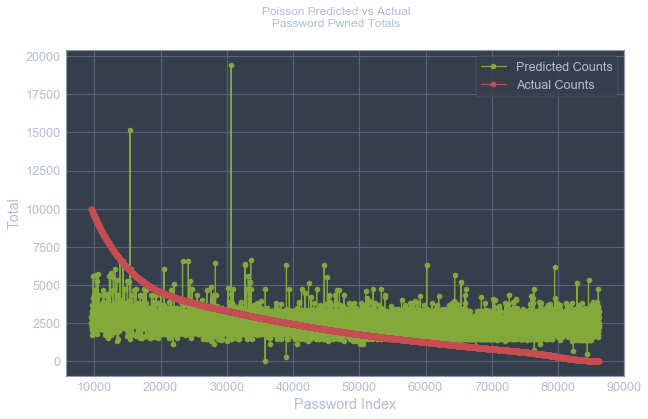

In [17]:
# Create poisson predicted and actual pwned totals to be plotted
pois_pred_cnt = pois_pred_df['mean']
pois_act_cnt = pois_y_test['Total']

# Plot poisson predicted vs actual pwned totals
pois_fig = plt.figure(figsize=(10,6))
pois_fig.suptitle('Poisson Predicted vs Actual\nPassword Pwned Totals')
pois_pred_plt, = plt.plot(pois_X_test.index, pois_pred_cnt, 'go-', label='Predicted Counts')
pois_act_plt, = plt.plot(pois_X_test.index, pois_act_cnt, 'ro-', label='Actual Counts')
plt.xlabel('Password Index')
plt.ylabel('Total')
plt.legend(handles=[pois_pred_plt, pois_act_plt])
plt.show()

In [18]:
# # Save poisson figure
# pois_fig.savefig('Visualizations/poisson.png')

# Visualizations

In [20]:
# Plot pwned total by password length


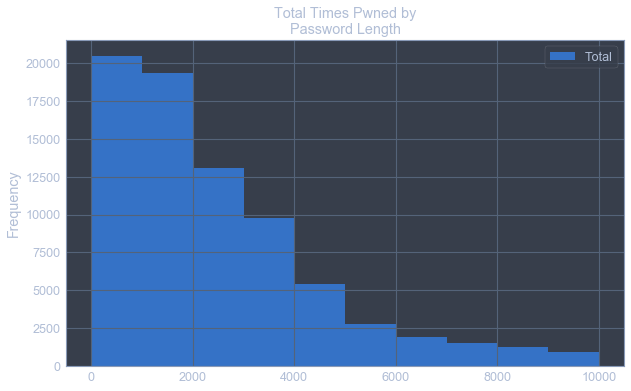

In [40]:
df.plot(x='Length', y='Total', kind='hist', figsize=(10,6))
plt.title('Total Times Pwned by\nPassword Length')
plt.show()

In [42]:
x = df['Length']
max(x)

20

In [41]:
df['Length'].sort_values()

9559      6
46580     6
46582     6
46585     6
46595     6
46597     6
46598     6
46599     6
46578     6
46600     6
46608     6
46609     6
46617     6
46620     6
46623     6
46626     6
46627     6
46602     6
46577     6
46576     6
46573     6
46539     6
46543     6
46545     6
46546     6
46550     6
46551     6
46553     6
46554     6
46558     6
         ..
46170    16
43621    16
53121    16
80475    16
44104    16
84324    16
28277    16
21459    16
29543    16
13479    16
43600    16
38988    16
18275    16
35789    16
32614    16
49346    16
20992    16
30651    16
12853    17
85047    17
76259    17
79422    17
70163    18
13608    19
33984    19
16568    19
18928    20
10257    20
12458    20
10769    20
Name: Length, Length: 76581, dtype: int64

In [ ]:
aaa